Pontificia Universidad Católica de Chile <br>
Departamento de Ingeniería Química y Bioprocesos <br>
IIQ2003 – Fenómenos de Transporte <br>
Segundo Semestre 2025 <br>

<h1><center>Proyecto: Transferencia de oxígeno en jaulas de salmones en Chile</center></h1>

Fecha: 9 de diciembre de 2025

Integrantes: Agustín León / Alonso Martín / Maite Oportus / Martina Sánchez

Grupo 15

### Librerías

Se importan las librerías necesarias para ejecutar el código, las cuales son $\texttt{matplotlib}$ y $\texttt{numpy}$.

In [1]:
# Visualización de datos y gráficos
import matplotlib.pyplot as plt
# Computación numérica
import numpy as np

# Ejecución de código con valores estándar

Se hara una ejecución del algortimo para valores estándar (obtenidos de literatura) de una jaula de salmón y propiedades del oxígeno en el aire y en el mar, para después comparar los resultados con los de datos reales y evaluar la factibilidad del modelo propuesto a partir de la problemática estudiada.

In [ ]:
# Parámetros constantes conocidos

# Largo del receptáculo / [m]
Lx = 5

# Alto del receptáculo / [m]
H = Lx

# Difusividad de la especie oxígeno  [m^2*s^-1]
k = 1e-4

# Concentración inicial / [mol*m^-3]
w0 = 0

# Concentration de equilibrio en el mar / [mol*m^-3]
w_mar = 5

# Concentración interfase aire-agua  [mol*m^-3]
w_aire = 2

# Concentración en el fondo [mol*m^-3]
w_fondo = 10

#Consumo constante
sigma_const = 2e-7  # Tasa de consumo CONSTANTE [mg/l/s]

Se define la grilla para llevar a cabo la discretización.

In [ ]:
# Grilla estructurada en coordenadas x y z para representar receptáculo cuadrado

# Definimos el número de puntos deseados en nuestra grilla
Nx = 451
Nz = Nx

# Definimos vectores con las coordenadas de cada punto en el espacio donde se evaluará la solución.
x_grilla = np.linspace(0.0, Lx, Nx)
z_grilla = np.linspace(0.0, H, Nz)

# Calculamos el paso o espaciamiento para cada coordenada.
dx = Lx/(Nx-1)
dz = H/(Nz-1)

dx = 0.011, dz = 0.011 m


Con la grilla definida se modelan los transportes difusivo y convectivo.

### Transporte difusivo

En los siguientes bloques de código, se modela el transporte de oxígeno mediante difusión. Primer se definen los coeficientes constantes y los parámetros para la discretización. Se utiliza un valor de tolerancia de $2*10^{-3}$ para privilegiar la entrega rápida de resultados, además de no haber diferencias significativas entre usar un valor de $2*10^{-4}$.

In [ ]:
#Definir valores de coeficientes constantes

# Coeficiente correspondiente a nodo vecino derecho
a = k/(dx**2)

# Coeficiente correspondiente a nodo vecino izquierdo
b = k/(dx**2) #varía -vx/dx

# Coeficiente correspondiente a nodo vecino superior
c = k/(dz**2)

# Coeficiente correspondiente a nodo vecino inferior
d = k/(dz**2)  #varía -vz/dz

# Coeficiente correspondiente a nodo central
e = -2*k/(dx**2) - 2*k/(dz**2)  #varía +vx/dx + vz/dz

#REVISAR VALOR
# Coeficiente correspondiente a término constante
f = sigma_const

# Definir valores constantes para parámetros SOR

# Parámetro de sobre-relajación
omega = 1.45

# Tolerancia, criterio de convergencia
tol = 2*1e-3

Se lleva a cabo la discretización mediante el método de sobre-relajación sucesiva (SOR).

In [7]:
w_fondo2 = 100

# Algoritmo de iteración por SOR

# Inicializamos arreglo para almacenar los valores solución de la concentration de oxígeno
wA2 = np.ones((Nx,Nz)) * w0 #*concentración al inicial

# Aplicamos las condiciones de borde

# borde "superior" (x, z=0) esto es para todo i en j = 0
wA2[:,0] = w_aire

# borde derecho (x=L, z) esto es en i = Nx-1 para 1 <= j <= Nz-1
wA2[-1,1:] = (4*wA2[-2, 1:] - wA2[-3, 1:])/3

# borde "inferior" (x, z=H) esto es para 0 <= i <= Nx-2 en j = Nz-1
wA2[0:-1, -1] = w_fondo2

# borde izquierdo (x=0, z) esto es en i = 0 para 1 <= j <=  Ny-1
wA2[0, 1:-1] = w_mar

# Inicializamos el residuo total al comienzo de iteración con un valor arbitrario
residuo_total = 1

# Inicializamos contador para numero de iteraciones
cnt_it = 0

while residuo_total > tol:

    # Residuo viejo
    residuo_tmp = residuo_total

    # Reiniciar residuo total para sumar residuos en cada nodo
    resid_total = 0

    # Contador para checker boarding
    cnt_nodos = 0

    # Recorrer puntos internos del dominio
    for i in range(0,Nx):
        for j in range(0,Nz):

            # Checker-boarding para garantizar convergencia, resolviendo nodos pares e impares alternadamente
            if((i+j)%2) == cnt_it%2:

                # Calcular residuo para nodo (i,j)
                if (i > 0) & (i < Nx-1) & (j > 0) & (j < Nz-1):
                    residuo_nodo = a*wA2[i+1,j] + b*wA2[i-1,j] + c*wA2[i,j+1] + d*wA2[i, j-1] + e*wA2[i,j] - f


                    # Actualizar el valor de concentration de aroma
                    wA2[i,j] += -omega*residuo_nodo / e

                    # Actualizar la suma de residuos absolutos
                    residuo_total += abs(residuo_nodo)

                # Aumentar contador de nodos
                cnt_nodos += 1

    # Actualizar condiciones de borde arreglo solución de concentraciones
    # luego de un checker-boarding completo (nodos pares e impares)
    if cnt_it%2 == 0:
        # borde "superior" (x, z=0) esto es para todo i en j = 0
        wA2[:,0] = w_aire

        # borde derecho (x=L, z) esto es en i = Nx-1 para 1 <= j <= Nz-1
        wA2[-1,1:] = ( 4*wA2[-2, 1:] - wA2[-3, 1:])/3

        # borde "inferior" (x, z=H) esto es para 0 <= i <= Nx-2 en j = Nz-1
        wA2[0:-1, -1] = w_fondo2

        # borde izquierdo (x=0, z) esto es en i = 0 para 1 <= j <=  Ny-1
        wA2[0, 1:-1] = w_mar


    # Calcular residuo medio
    residuo_total = residuo_total/cnt_nodos


    # Imprimir residuo cada 100 iteraciones
    if cnt_it%100 ==0:
        print("Residuo total: %.3e" % residuo_total)

    # Aumentar contador de iteraciones
    cnt_it = cnt_it + 1

Residuo total: 1.918e-01
Residuo total: 4.732e-02
Residuo total: 3.316e-02
Residuo total: 2.688e-02
Residuo total: 2.314e-02
Residuo total: 2.059e-02
Residuo total: 1.871e-02
Residuo total: 1.724e-02
Residuo total: 1.606e-02
Residuo total: 1.508e-02
Residuo total: 1.426e-02
Residuo total: 1.355e-02
Residuo total: 1.293e-02
Residuo total: 1.238e-02
Residuo total: 1.189e-02
Residuo total: 1.145e-02
Residuo total: 1.106e-02
Residuo total: 1.069e-02
Residuo total: 1.036e-02
Residuo total: 1.006e-02
Residuo total: 9.779e-03
Residuo total: 9.519e-03
Residuo total: 9.276e-03
Residuo total: 9.049e-03
Residuo total: 8.837e-03
Residuo total: 8.638e-03
Residuo total: 8.450e-03
Residuo total: 8.273e-03
Residuo total: 8.105e-03
Residuo total: 7.946e-03
Residuo total: 7.795e-03
Residuo total: 7.652e-03
Residuo total: 7.515e-03
Residuo total: 7.384e-03
Residuo total: 7.260e-03
Residuo total: 7.140e-03
Residuo total: 7.026e-03
Residuo total: 6.916e-03
Residuo total: 6.811e-03
Residuo total: 6.710e-03


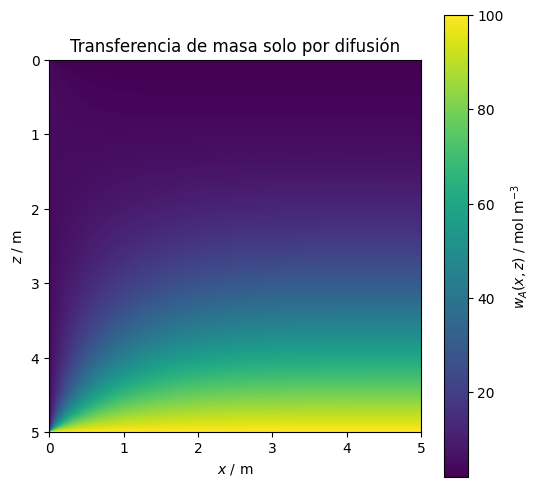

In [8]:
# Creamos el lienzo para graficar
fig = plt.subplots(figsize=[6,6])

#Invertimos la coordenada vertical de la matriz cA, ya que computacionalmente
#el índice "j", asociado a la coordenada y, avanza hacia "abajo" mientras que en 
#el dominio físico avanza hacia arriba.

plt.imshow((np.transpose(wA2)), origin="upper", extent =[0, Lx,H,0])
plt.colorbar(label=r"$w_A(x,z)$ / mol m$^{-3}$")
plt.xlabel(r'$x$ / m')
plt.ylabel(r'$z$ / m')
plt.title("Transferencia de masa solo por difusión")

plt.show()

### Transporte convectivo (advección)

Para la convección, se definen las velocidades en las direcciones $x$ y $z$. Se utiliza una tolerancia de $2\cdot 10^-4$

In [9]:
vx = 10 #m/s
vz = 2 #m/s
omega = 1 #Se disminuye el valor de omega para modelar la convección, evitando divergencia.
tol = 2*1e-4

Se definen los coeficientes constantes.

In [10]:
#Definir valores de coeficientes constantes

# Coeficiente correspondiente a nodo vecino derecho
a = 0

# Coeficiente correspondiente a nodo vecino izquierdo
b = -vx/dx

# Coeficiente correspondiente a nodo vecino superior
c = 0

# Coeficiente correspondiente a nodo vecino inferior
d = -vz/dz

# Coeficiente correspondiente a nodo central
e = vx/dx + vz/dz

#REVISAR VALOR
# Coeficiente correspondiente a término constante
f = sigma_const

Se lleva a cabo la discretización mediante el método de sobre-relajación sucesiva (SOR).

In [11]:
# Algoritmo de iteración por SOR

# Inicializamos arreglo para almacenar los valores solución de la concentration de oxígeno
wA3 = np.ones((Nx,Nz)) * w0 #*concentración al inicial

# Aplicamos las condiciones de borde

# borde "superior" (x, z=0) esto es para todo i en j = 0
wA3[:,0] = w_aire

# borde derecho (x=L, z) esto es en i = Nx-1 para 1 <= j <= Nz-1
wA3[-1,1:] = ( 4*wA3[-2, 1:] - wA3[-3, 1:])/3

# borde "inferior" (x, z=H) esto es para 0 <= i <= Nx-2 en j = Nz-1
wA3[0:-1, -1] = w_fondo

# borde izquierdo (x=0, z) esto es en i = 0 para 1 <= j <=  Ny-1
wA3[0, 1:-1] = w_mar

# Inicializamos el residuo total al comienzo de iteración con un valor arbitrario
residuo_total = 1

# Inicializamos contador para numero de iteraciones
cnt_it = 0

while residuo_total > tol:

    # Residuo viejo
    residuo_tmp = residuo_total

    # Reiniciar residuo total para sumar residuos en cada nodo
    resid_total = 0

    # Contador para checker boarding
    cnt_nodos = 0

    # Recorrer puntos internos del dominio
    for i in range(0,Nx):
        for j in range(0,Nz):

            # Checker-boarding para garantizar convergencia, resolviendo nodos pares e impares alternadamente
            if((i+j)%2) == cnt_it%2:

                # Calcular residuo para nodo (i,j)
                if (i > 0) & (i < Nx-1) & (j > 0) & (j < Nz-1):
                    residuo_nodo = a*wA3[i+1,j] + b*wA3[i-1,j] + c*wA3[i,j+1] + d*wA3[i, j-1] + e*wA3[i,j] - f

                    # Actualizar el valor de concentration de aroma
                    wA3[i,j] += -omega*residuo_nodo/e

                    # Actualizar la suma de residuos absolutos
                    residuo_total += abs(residuo_nodo)

                # Aumentar contador de nodos
                cnt_nodos += 1

    # Actualizar condiciones de borde arreglo solución de concentraciones
    # luego de un checker-boarding completo (nodos pares e impares)
    if cnt_it%2 == 0:
        # borde "superior" (x, z=0) esto es para todo i en j = 0
        wA3[:,0] = w_aire

        # borde derecho (x=L, z) esto es en i = Nx-1 para 1 <= j <= Nz-1
        wA3[-1,1:] = (4*wA3[-2, 1:] - wA3[-3, 1:])/3

        # borde "inferior" (x, z=H) esto es para 0 <= i <= Nx-2 en j = Nz-1
        wA3[0:-1, -1] = w_fondo

        # borde izquierdo (x=0, z) esto es en i = 0 para 1 <= j <=  Ny-1
        wA3[0, 1:-1] = w_mar

    # Calcular residuo medio
    residuo_total = residuo_total/cnt_nodos

    # Imprimir residuo cada 100 iteraciones
    if cnt_it%100 ==0:
        print("Residuo total: %.3e" % residuo_total)

    # Aumentar contador de iteraciones
    cnt_it = cnt_it + 1

Residuo total: 1.075e+01
Residuo total: 2.043e+01
Residuo total: 1.940e+01
Residuo total: 1.836e+01
Residuo total: 1.733e+01
Residuo total: 1.630e+01


Se grafican los resultados.

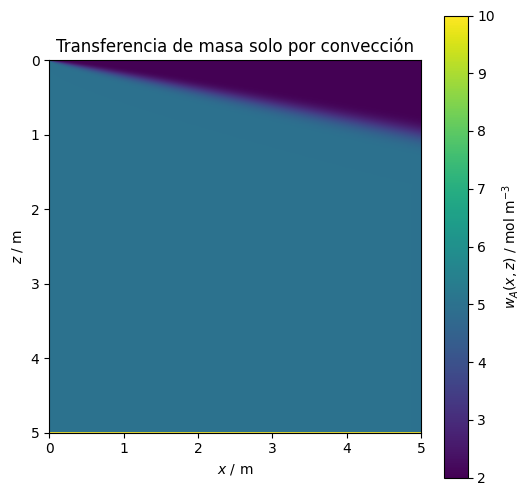

In [12]:
# Creamos el lienzo para graficar
fig = plt.subplots(figsize=[6,6])

'''Invertimos la coordenada vertical de la matriz cA, ya que computacionalmente 
el índice "j", asociado a la coordenada y, avanza hacia "abajo" mientras que en el dominio físico avanza hacia arriba'''

plt.imshow((np.transpose(wA3)), origin="upper", extent =[0, Lx,H,0])
plt.colorbar(label=r"$w_A(x,z)$ / mol m$^{-3}$")
plt.xlabel(r'$x$ / m')
plt.ylabel(r'$z$ / m')
plt.title("Transferencia de masa solo por convección")

plt.show()

### Acoplando ambos transportes

Ahora se modela la transferencia de masa considerando ambos tipos de transporte (convectivo y difusivo).

In [13]:
#Definir valores de coeficientes constantes

# Coeficiente correspondiente a nodo vecino derecho
a = k/(dx**2)

# Coeficiente correspondiente a nodo vecino izquierdo
b = k/(dx**2) -vx/dx

# Coeficiente correspondiente a nodo vecino superior
c = k/(dz**2)

# Coeficiente correspondiente a nodo vecino inferior
d = k/(dz**2) -vz/dz

# Coeficiente correspondiente a nodo central
e = -2*k/(dx**2) - 2*k/(dz**2) + vx/dx + vz/dz

#REVISAR VALOR
# Coeficiente correspondiente a término constante
f = sigma_const

Se lleva a cabo la discretización mediante el método de sobre-relajación sucesiva (SOR).

In [14]:
# Algoritmo de iteración por SOR

# Inicializamos arreglo para almacenar los valores solución de la concentration de oxígeno
wA4 = np.ones((Nx,Nz)) * w0 #*concentración al inicial

# Aplicamos las condiciones de borde

# borde "superior" (x, z=0) esto es para todo i en j = 0
wA4[:,0] = w_aire

# borde derecho (x=L, z) esto es en i = Nx-1 para 1 <= j <= Nz-1
wA4[-1,1:] = (4*wA4[-2, 1:] - wA4[-3, 1:])/3

# borde "inferior" (x, z=H) esto es para 0 <= i <= Nx-2 en j = Nz-1
wA4[0:-1, -1] = w_fondo

# borde izquierdo (x=0, z) esto es en i = 0 para 1 <= j <=  Ny-1
wA4[0, 1:-1] = w_mar

# Inicializamos el residuo total al comienzo de iteración con un valor arbitrario
residuo_total = 1

# Inicializamos contador para numero de iteraciones
cnt_it = 0

while residuo_total > tol:

    # Residuo viejo
    residuo_tmp = residuo_total

    # Reiniciar residuo total para sumar residuos en cada nodo
    resid_total = 0

    # Contador para checker boarding
    cnt_nodos = 0

    # Recorrer puntos internos del dominio
    for i in range(0,Nx):
        for j in range(0,Nz):

            # Checker-boarding para garantizar convergencia, resolviendo nodos pares e impares alternadamente
            if((i+j)%2) == cnt_it%2:

                # Calcular residuo para nodo (i,j)
                if (i > 0) & (i < Nx-1) & (j > 0) & (j < Nz-1):
                    residuo_nodo = a*wA4[i+1,j] + b*wA4[i-1,j] + c*wA4[i,j+1] + d*wA4[i, j-1] + e*wA4[i,j] - f


                    # Actualizar el valor de concentration de aroma
                    wA4[i,j] += -omega*residuo_nodo / e

                    # Actualizar la suma de residuos absolutos
                    residuo_total += abs(residuo_nodo)

                # Aumentar contador de nodos
                cnt_nodos += 1

    # Actualizar condiciones de borde arreglo solución de concentraciones
    # luego de un checker-boarding completo (nodos pares e impares)
    if cnt_it%2 == 0:
        # borde "superior" (x, z=0) esto es para todo i en j = 0
        wA4[:,0] = w_aire

        # borde derecho (x=L, z) esto es en i = Nx-1 para 1 <= j <= Nz-1
        wA4[-1,1:] = ( 4*wA4[-2, 1:] - wA4[-3, 1:])/3

        # borde "inferior" (x, z=H) esto es para 0 <= i <= Nx-2 en j = Nz-1
        wA4[0:-1, -1] = w_fondo

        # borde izquierdo (x=0, z) esto es en i = 0 para 1 <= j <=  Ny-1
        wA4[0, 1:-1] = w_mar


    # Calcular residuo medio
    residuo_total = residuo_total/cnt_nodos


    # Imprimir residuo cada 100 iteraciones
    if cnt_it%100 ==0:
        print("Residuo total: %.3e" % residuo_total)


    # Aumentar contador de iteraciones
    cnt_it = cnt_it + 1

Residuo total: 1.076e+01
Residuo total: 2.046e+01
Residuo total: 1.946e+01
Residuo total: 1.847e+01
Residuo total: 1.749e+01
Residuo total: 1.652e+01


Se grafican los resultados.

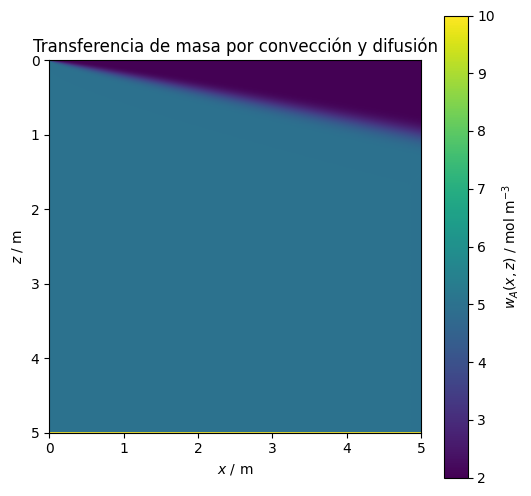

In [15]:
# Creamos el lienzo para graficar
fig = plt.subplots(figsize=[6,6])

'''Invertimos la coordenada vertical de la matriz cA, ya que computacionalmente el índice "j", asociado a la coordenada y, avanza hacia "abajo" mientras que en el dominio físico avanza hacia arriba'''

plt.imshow((np.transpose(wA4)), origin="upper", extent =[0, Lx,H,0])
plt.colorbar(label=r"$w_A(x,z)$ / mol m$^{-3}$")
plt.xlabel(r'$x$ / m')
plt.ylabel(r'$z$ / m')
plt.title("Transferencia de masa por convección y difusión")

plt.show()

# Ejecución con valores conocidos

Ahora se repite el procedimiento, usando datos reales de la producción de salmones en Puerto Montt. Sin embargo, por razones de convergencia, se consideran jaulas cuadradas.

In [16]:
# Parámetros constantes conocidos

# Largo de la jaula / m
Lx = 2

# Profundidad de la jaula / m
H = 1

# Ancho de la jaula / m
A = Lx

# Difusividad de la especie oxígeno  [m^2 s^-1]
k = 2 * 10**(-9)

# Concentración inicial   [mol m^-3]
w0 = 0

# Concentración de equilibrio en el mar  [mol m^-3]
w_mar = 0.29

# Concentración interfase aire-agua  [mol m^-3]
w_aire = 0.329

# Concentración en el fondo   [mol m^-3]
w_fondo = 1

#Velocidad
vx = 0.0972 #m/s
vz = vx #m/s

Se definen las propiedades del agua y salmón requeridas para la producción, además de la tasa de consumo, la cual es constante.

In [17]:
P = 3 #kg
T = 13.3 #°C
U = 2.2
VwA = 0.0171 * P**(-0.33) * 1.03**(T) * 1.79**(U)
Nk = 50000/15
Wk= P
Volumen = Lx * H * A
#Consumo constante
sigma_const = -VwA * Nk * Wk * 1/Volumen # Tasa de consumo CONSTANTE [mg/l/s]
print(sigma_const)

-158.67111067241854


Ahora se define la grilla para la discretización.

In [18]:
# Grilla estructurada en coordenadas x y z para representar receptáculo cuadrado

# Definimos el número de puntos deseados en nuestra grilla
Nx = 151
Nz = Nx // 2

# Definimos vectores con las coordenadas de cada punto en el espacio donde se evaluará la solución.
x_grilla = np.linspace(0.0, Lx, Nx)
z_grilla = np.linspace(0.0, H, Nz)

# Calculamos el paso o espaciamiento para cada coordenada.
dx = Lx/(Nx-1)
dz = H/(Nz-1)

# Imprimimos los resultados
print("dx = %.3f, dz = %.3f m" % (dx, dz))

dx = 0.013, dz = 0.014 m


Graficando la grilla recién definida:

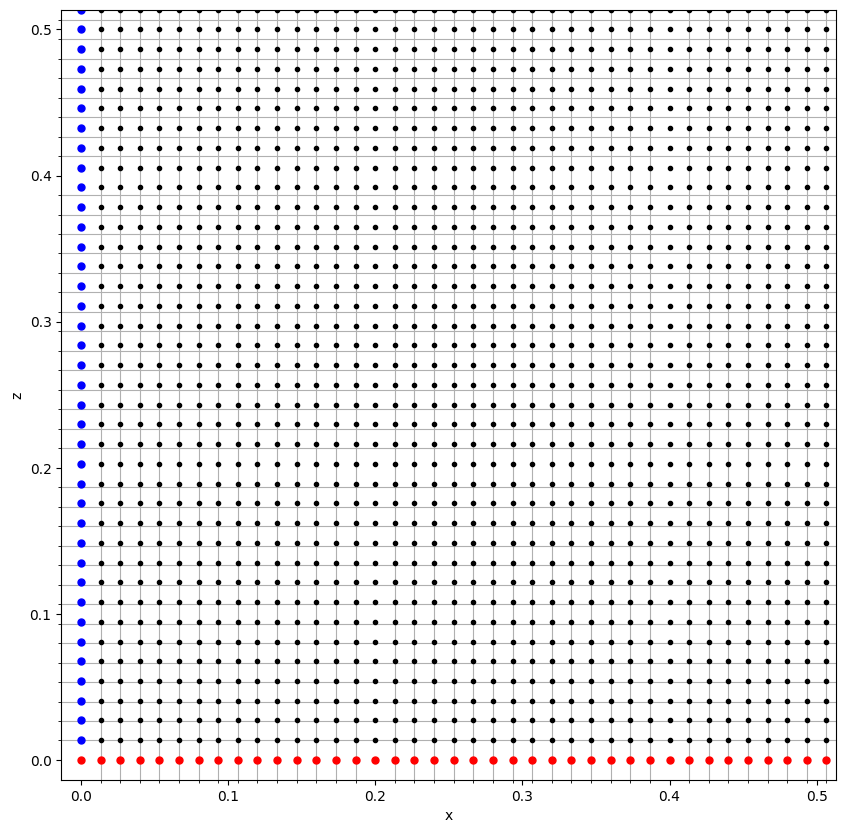

In [19]:
#Visualización de la grilla computacional
fig, ax = plt.subplots(figsize = (10,10))

X,Y = np.meshgrid(x_grilla, z_grilla)
ax.plot(X, Y, 'k.')

# Condición de borde de Dirichlet
ax.plot(X[0,:], Y[0,:], 'r.', markersize=10)

# Condiciones de borde de Neumann en azul

# Borde superior
ax.plot(X[-1,:], Y[-1,:], 'b.', markersize=10)

# Borde izquierdo
ax.plot(X[1:,0], Y[1:,0], 'b.', markersize=10)

# Borde derecho
ax.plot(X[1:,-1], Y[1:,-1], 'b.', markersize=10)

ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_xticks(x_grilla, minor=True)

ax.set_yticks(x_grilla, minor=True)
ax.grid(which= 'minor')


ax.set_xlim(0-dx,0.5 + dx)
ax.set_ylim(0 - dz, 0.5 + dz)
plt.show()

Con la grilla creada, se procede a modelar los diferentes tipos de transporte de masa.

### Transporte difusivo

Se definen los coeficientes constantes y los parámetros para la discretización.

In [20]:
#Definir valores de coeficientes constantes

# Coeficiente correspondiente a nodo vecino derecho
a = k/(dx**2)

# Coeficiente correspondiente a nodo vecino izquierdo
b = k/(dx**2) #varía -vx/dx

# Coeficiente correspondiente a nodo vecino superior
c = k/(dz**2)

# Coeficiente correspondiente a nodo vecino inferior
d = k/(dz**2)  #varía -vz/dz

# Coeficiente correspondiente a nodo central
e = -2*k/(dx**2) - 2*k/(dz**2)  #varía +vx/dx + vz/dz

#REVISAR VALOR
# Coeficiente correspondiente a término constante
f = sigma_const

# Definir valores constantes para parámetros SOR

# Parámetro de sobre-relajación
omega = 1.45

# Tolerancia, criterio de convergencia
tol = 2*1e-3 # -> ideal es 10**-4 pero para hacer que converja más rápido

Se lleva a cabo la discretización mediante el método de sobre-relajación sucesiva (SOR).

In [21]:
# Algoritmo de iteración por SOR

# Inicializamos arreglo para almacenar los valores solución de la concentration de oxígeno
wA = np.ones((Nx,Nz)) * w0 #*concentración al inicial

# Aplicamos las condiciones de borde

# borde "superior" (x, z=0) esto es para todo i en j = 0
wA[:,0] = w_aire

# borde derecho (x=L, z) esto es en i = Nx-1 para 1 <= j <= Nz-1
wA[-1,1:] = ( 4*wA[-2, 1:] - wA[-3, 1:])/3

# borde "inferior" (x, z=H) esto es para 0 <= i <= Nx-2 en j = Nz-1
wA[0:-1, -1] = w_fondo

# borde izquierdo (x=0, z) esto es en i = 0 para 1 <= j <=  Ny-1
wA[0, 1:-1] = w_mar

# Inicializamos el residuo total al comienzo de iteración con un valor arbitrario
residuo_total = 1

# Inicializamos contador para numero de iteraciones
cnt_it = 0

while residuo_total > tol:

    # Residuo viejo
    residuo_tmp = residuo_total

    # Reiniciar residuo total para sumar residuos en cada nodo
    resid_total = 0

    # Contador para checker boarding
    cnt_nodos = 0

    # Recorrer puntos internos del dominio
    for i in range(0,Nx):
        for j in range(0,Nz):

            # Checker-boarding para garantizar convergencia, resolviendo nodos pares e impares alternadamente
            if((i+j)%2) == cnt_it%2:

                # Calcular residuo para nodo (i,j)
                if (i > 0) & (i < Nx-1) & (j > 0) & (j < Nz-1):
                    residuo_nodo = a*wA[i+1,j] + b*wA[i-1,j] + c*wA[i,j+1] + d*wA[i, j-1] + e*wA[i,j] - f


                    # Actualizar el valor de concentration de aroma
                    wA[i,j] += -omega*residuo_nodo / e

                    # Actualizar la suma de residuos absolutos
                    residuo_total += abs(residuo_nodo)

                # Aumentar contador de nodos
                cnt_nodos += 1

    # Actualizar condiciones de borde arreglo solución de concentraciones
    # luego de un checker-boarding completo (nodos pares e impares)
    if cnt_it%2 == 0:
        # borde "superior" (x, z=0) esto es para todo i en j = 0
        wA[:,0] = w_aire

        # borde derecho (x=L, z) esto es en i = Nx-1 para 1 <= j <= Nz-1
        wA[-1,1:] = ( 4*wA[-2, 1:] - wA[-3, 1:])/3

        # borde "inferior" (x, z=H) esto es para 0 <= i <= Nx-2 en j = Nz-1
        wA[0:-1, -1] = w_fondo

        # borde izquierdo (x=0, z) esto es en i = 0 para 1 <= j <=  Ny-1
        wA[0, 1:-1] = w_mar

    # Calcular residuo medio
    residuo_total = residuo_total/cnt_nodos

    # Imprimir residuo cada 100 iteraciones
    if cnt_it%100 ==0:
        print("Residuo total: %.3e" % residuo_total)

    # Aumentar contador de iteraciones
    cnt_it = cnt_it + 1

Residuo total: 1.524e+02
Residuo total: 3.976e+02
Residuo total: 3.344e+02
Residuo total: 2.881e+02
Residuo total: 2.506e+02
Residuo total: 2.190e+02
Residuo total: 1.918e+02
Residuo total: 1.682e+02
Residuo total: 1.477e+02
Residuo total: 1.298e+02
Residuo total: 1.141e+02
Residuo total: 1.003e+02
Residuo total: 8.830e+01
Residuo total: 7.773e+01
Residuo total: 6.844e+01
Residuo total: 6.029e+01
Residuo total: 5.312e+01
Residuo total: 4.681e+01
Residuo total: 4.127e+01
Residuo total: 3.638e+01
Residuo total: 3.208e+01
Residuo total: 2.830e+01
Residuo total: 2.496e+01
Residuo total: 2.202e+01
Residuo total: 1.943e+01
Residuo total: 1.715e+01
Residuo total: 1.514e+01
Residuo total: 1.336e+01
Residuo total: 1.179e+01
Residuo total: 1.041e+01
Residuo total: 9.194e+00
Residuo total: 8.119e+00
Residuo total: 7.170e+00
Residuo total: 6.332e+00
Residuo total: 5.593e+00
Residuo total: 4.940e+00
Residuo total: 4.364e+00
Residuo total: 3.855e+00
Residuo total: 3.406e+00
Residuo total: 3.009e+00


Se grafica el perfil de concentración de $O_2$ por difusión:

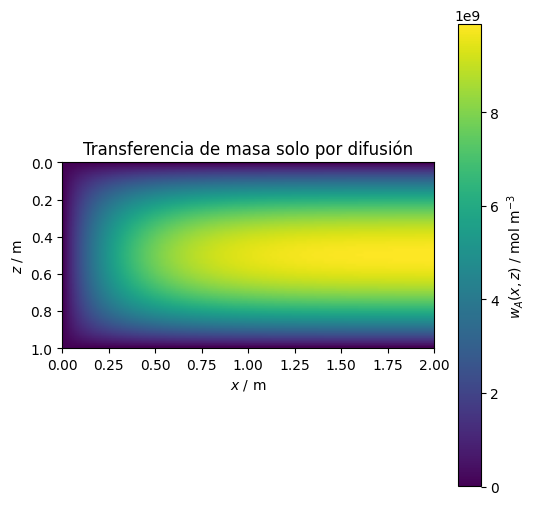

In [22]:
# Creamos el lienzo para graficar
fig = plt.subplots(figsize=[6,6])

'''Invertimos la coordenada vertical de la matriz cA, ya que computacionalmente el índice "j", asociado a la coordenada y, avanza hacia "abajo" mientras que en el dominio físico avanza hacia arriba'''

plt.imshow((np.transpose(wA)), origin="upper", extent =[0, Lx,H,0])
plt.colorbar(label=r"$w_A(x,z)$ / mol m$^{-3}$")
plt.xlabel(r'$x$ / m')
plt.ylabel(r'$z$ / m')
plt.title("Transferencia de masa solo por difusión")

plt.show()

### Transporte convectivo

Ahora se modela el transporte convectivo, cambiando el valor de $\omega$ por motivos de convergencia.

In [23]:
omega = 1

Se definen los coeficientes constantes.

In [24]:
#Definir valores de coeficientes constantes

# Coeficiente correspondiente a nodo vecino derecho
a = 0

# Coeficiente correspondiente a nodo vecino izquierdo
b = vx/dx

# Coeficiente correspondiente a nodo vecino superior
c = 0

# Coeficiente correspondiente a nodo vecino inferior
d = vz/dz

# Coeficiente correspondiente a nodo central
e = -(vx/dx + vz/dz)

#REVISAR VALOR
# Coeficiente correspondiente a término constante
f = sigma_const

Se lleva a cabo la discretización mediante el método de sobre-relajación sucesiva (SOR).

In [25]:
# Algoritmo de iteración por SOR

# Inicializamos arreglo para almacenar los valores solución de la concentration de oxígeno
wA2 = np.ones((Nx,Nz)) * w0 #*concentración al inicial

# Aplicamos las condiciones de borde

# borde "superior" (x, z=0) esto es para todo i en j = 0
wA2[:,0] = w_aire

# borde derecho (x=L, z) esto es en i = Nx-1 para 1 <= j <= Nz-1
wA2[-1,1:] = ( 4*wA2[-2, 1:] - wA2[-3, 1:])/3

# borde "inferior" (x, z=H) esto es para 0 <= i <= Nx-2 en j = Nz-1
wA2[0:-1, -1] = w_fondo

# borde izquierdo (x=0, z) esto es en i = 0 para 1 <= j <=  Ny-1
wA2[0, 1:-1] = w_mar

# Inicializamos el residuo total al comienzo de iteración con un valor arbitrario
residuo_total = 1

# Inicializamos contador para numero de iteraciones
cnt_it = 0

while residuo_total > tol:

    # Residuo viejo
    residuo_tmp = residuo_total

    # Reiniciar residuo total para sumar residuos en cada nodo
    resid_total = 0

    # Contador para checker boarding
    cnt_nodos = 0

    # Recorrer puntos internos del dominio
    for i in range(0,Nx):
        for j in range(0,Nz):

            # Checker-boarding para garantizar convergencia, resolviendo nodos pares e impares alternadamente
            if((i+j)%2) == cnt_it%2:

                # Calcular residuo para nodo (i,j)
                if (i > 0) & (i < Nx-1) & (j > 0) & (j < Nz-1):
                    residuo_nodo = a*wA2[i+1,j] + b*wA2[i-1,j] + c*wA2[i,j+1] + d*wA2[i, j-1] + e*wA2[i,j] - f

                    # Actualizar el valor de concentration de aroma
                    wA2[i,j] += -omega*residuo_nodo/e

                    # Actualizar la suma de residuos absolutos
                    residuo_total += abs(residuo_nodo)

                # Aumentar contador de nodos
                cnt_nodos += 1

    # Actualizar condiciones de borde arreglo solución de concentraciones
    # luego de un checker-boarding completo (nodos pares e impares)
    if cnt_it%2 == 0:
        # borde "superior" (x, z=0) esto es para todo i en j = 0
        wA2[:,0] = w_aire

        # borde derecho (x=L, z) esto es en i = Nx-1 para 1 <= j <= Nz-1
        wA2[-1,1:] = (4*wA2[-2, 1:] - wA2[-3, 1:])/3

        # borde "inferior" (x, z=H) esto es para 0 <= i <= Nx-2 en j = Nz-1
        wA2[0:-1, -1] = w_fondo

        # borde izquierdo (x=0, z) esto es en i = 0 para 1 <= j <=  Ny-1
        wA2[0, 1:-1] = w_mar

    # Calcular residuo medio
    residuo_total = residuo_total/cnt_nodos

    # Imprimir residuo cada 100 iteraciones
    if cnt_it%100 ==0:
        print("Residuo total: %.3e" % residuo_total)

    # Aumentar contador de iteraciones
    cnt_it = cnt_it + 1

Residuo total: 1.524e+02
Residuo total: 6.474e+01


Se grafica el perfil de concentración para este transporte:

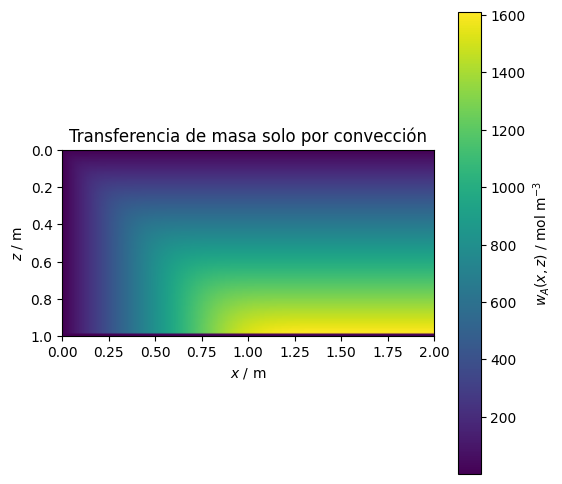

In [26]:
# Creamos el lienzo para graficar
fig = plt.subplots(figsize=[6,6])

'''Invertimos la coordenada vertical de la matriz cA, ya que computacionalmente
el índice "j", asociado a la coordenada y, avanza hacia "abajo" mientras que en el dominio físico avanza hacia arriba'''

plt.imshow((np.transpose(wA2)), origin="upper", extent =[0, Lx,H,0])
plt.colorbar(label=r"$w_A(x,z)$ / mol m$^{-3}$")
plt.xlabel(r'$x$ / m')
plt.ylabel(r'$z$ / m')
plt.title("Transferencia de masa solo por convección")

plt.show()

### Acoplando ambos transportes

Ahora se modela la transferencia de masa considerando transporte difusivo y convectivo.

In [27]:
#Definir valores de coeficientes constantes

# Coeficiente correspondiente a nodo vecino derecho
a = k/(dx**2)

# Coeficiente correspondiente a nodo vecino izquierdo
b = k/(dx**2) -vx/dx

# Coeficiente correspondiente a nodo vecino superior
c = k/(dz**2)

# Coeficiente correspondiente a nodo vecino inferior
d = k/(dz**2) -vz/dz

# Coeficiente correspondiente a nodo central
e = -2*k/(dx**2) - 2*k/(dz**2) +vx/dx + vz/dz

#REVISAR VALOR
# Coeficiente correspondiente a término constante
f = sigma_const

Se lleva a cabo la discretización mediante el método de sobre-relajación sucesiva (SOR).

In [28]:
# Algoritmo de iteración por SOR

# Inicializamos arreglo para almacenar los valores solución de la concentration de oxígeno
wA3 = np.ones((Nx,Nz)) * w0 #*concentración al inicial

# Aplicamos las condiciones de borde

# borde "superior" (x, z=0) esto es para todo i en j = 0
wA3[:,0] = w_aire

# borde derecho (x=L, z) esto es en i = Nx-1 para 1 <= j <= Nz-1
wA3[-1,1:] = ( 4*wA3[-2, 1:] - wA3[-3, 1:])/3

# borde "inferior" (x, z=H) esto es para 0 <= i <= Nx-2 en j = Nz-1
wA3[0:-1, -1] = w_fondo

# borde izquierdo (x=0, z) esto es en i = 0 para 1 <= j <=  Ny-1
wA3[0, 1:-1] = w_mar

# Inicializamos el residuo total al comienzo de iteración con un valor arbitrario
residuo_total = 1

# Inicializamos contador para numero de iteraciones
cnt_it = 0

while residuo_total > tol:

    # Residuo viejo
    residuo_tmp = residuo_total

    # Reiniciar residuo total para sumar residuos en cada nodo
    resid_total = 0

    # Contador para checker boarding
    cnt_nodos = 0

    # Recorrer puntos internos del dominio
    for i in range(0,Nx):
        for j in range(0,Nz):

            # Checker-boarding para garantizar convergencia, resolviendo nodos pares e impares alternadamente
            if((i+j)%2) == cnt_it%2:

                # Calcular residuo para nodo (i,j)
                if (i > 0) & (i < Nx-1) & (j > 0) & (j < Nz-1):
                    residuo_nodo = a*wA3[i+1,j] + b*wA3[i-1,j] + c*wA3[i,j+1] + d*wA3[i, j-1] + e*wA3[i,j] - f


                    # Actualizar el valor de concentration de aroma
                    wA3[i,j] += -omega*residuo_nodo / e

                    # Actualizar la suma de residuos absolutos
                    residuo_total += abs(residuo_nodo)

                # Aumentar contador de nodos
                cnt_nodos += 1

    # Actualizar condiciones de borde arreglo solución de concentraciones
    # luego de un checker-boarding completo (nodos pares e impares)
    if cnt_it%2 == 0:
        # borde "superior" (x, z=0) esto es para todo i en j = 0
        wA3[:,0] = w_aire

        # borde derecho (x=L, z) esto es en i = Nx-1 para 1 <= j <= Nz-1
        wA3[-1,1:] = ( 4*wA3[-2, 1:] - wA3[-3, 1:])/3

        # borde "inferior" (x, z=H) esto es para 0 <= i <= Nx-2 en j = Nz-1
        wA3[0:-1, -1] = w_fondo

        # borde izquierdo (x=0, z) esto es en i = 0 para 1 <= j <=  Ny-1
        wA3[0, 1:-1] = w_mar


    # Calcular residuo medio
    residuo_total = residuo_total/cnt_nodos


    # Imprimir residuo cada 100 iteraciones
    if cnt_it%100 ==0:
        print("Residuo total: %.3e" % residuo_total)


    # Aumentar contador de iteraciones
    cnt_it = cnt_it + 1

Residuo total: 1.523e+02
Residuo total: 6.464e+01


Se grafica el perfil de concentración.

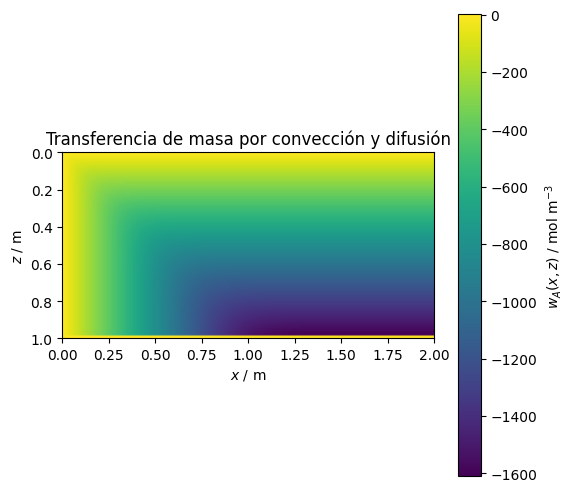

In [29]:
# Creamos el lienzo para graficar
fig = plt.subplots(figsize=[6,6])

'''Invertimos la coordenada vertical de la matriz cA, ya que computacionalmente el índice "j", asociado a la coordenada y, avanza hacia "abajo" mientras que en el dominio físico avanza hacia arriba'''

plt.imshow((np.transpose(wA3)), origin="upper", extent =[0, Lx,H,0])
plt.colorbar(label=r"$w_A(x,z)$ / mol m$^{-3}$")
plt.xlabel(r'$x$ / m')
plt.ylabel(r'$z$ / m')
plt.title("Transferencia de masa por convección y difusión")

plt.show()

Se grafican los perfiles de concentración a distintas profundidades, para los casos de sólo difusión, sólo convección y ambos transportes:

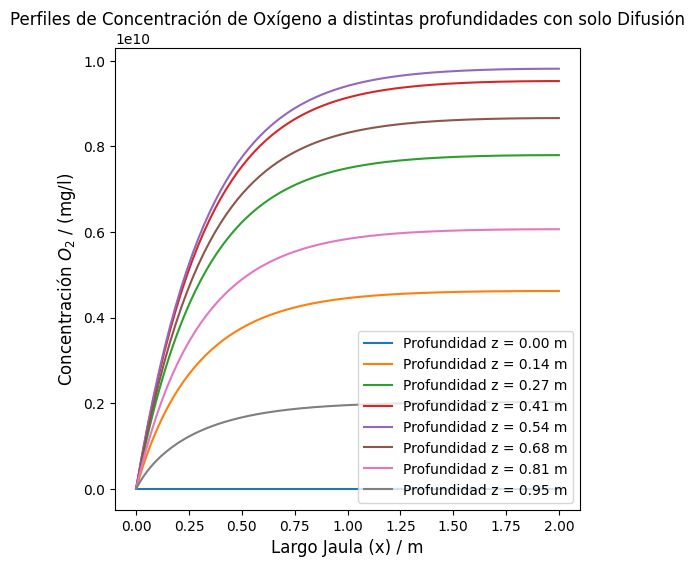

In [30]:
x_vec = np.linspace(0, Lx, Nx)
z_vec = np.linspace(0, H, Nz)

plt.figure(figsize=[6, 6])

# Se grafica un perfil para espaciamientos igual a 10*dz
for i in range(0, len(z_vec), 10):
    plt.plot(x_vec, wA[:, i], label="Profundidad z = %.2f m" % z_vec[i])


plt.title("Perfiles de Concentración de Oxígeno a distintas profundidades con solo Difusión")
plt.xlabel('Largo Jaula (x) / m', size=12)
plt.ylabel('Concentración $O_2$ / (mg/l)', size=12)
plt.tick_params(labelsize=10)


plt.legend()

plt.show()

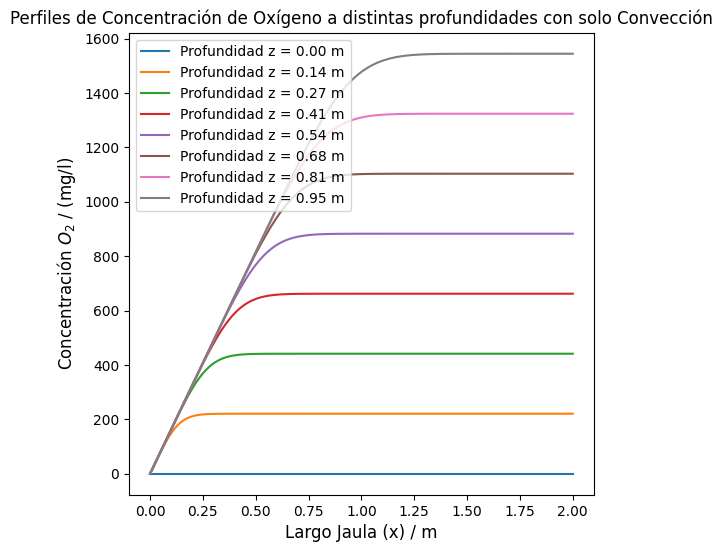

In [31]:
x_vec = np.linspace(0, Lx, Nx)
z_vec = np.linspace(0, H, Nz)

plt.figure(figsize=[6, 6])

# Se grafica un perfil para espaciamientos igual a 10*dz
for i in range(0, len(z_vec), 10):
    plt.plot(x_vec, wA2[:, i], label="Profundidad z = %.2f m" % z_vec[i])

plt.title("Perfiles de Concentración de Oxígeno a distintas profundidades con solo Convección")
plt.xlabel('Largo Jaula (x) / m', size=12)
plt.ylabel('Concentración $O_2$ / (mg/l)', size=12)
plt.tick_params(labelsize=10)

plt.legend()

plt.show()

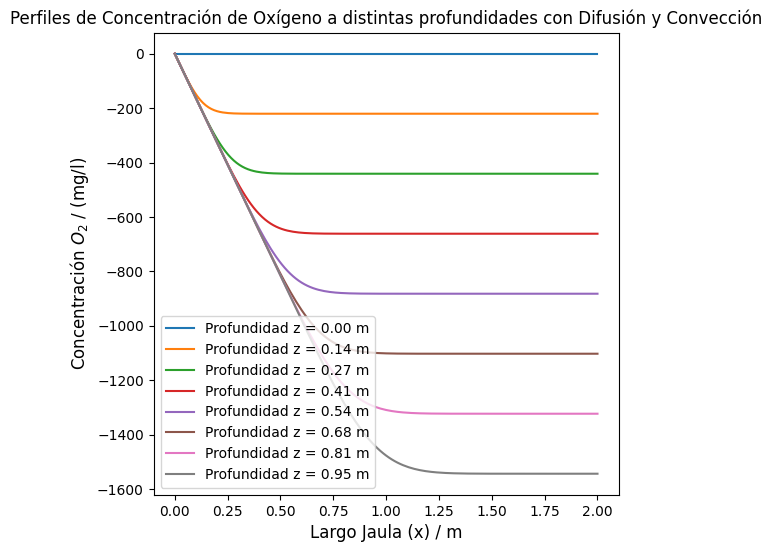

In [32]:
x_vec = np.linspace(0, Lx, Nx)
z_vec = np.linspace(0, H, Nz)

plt.figure(figsize=[6, 6])

# Se grafica un perfil para espaciamientos igual a 10*dz
for i in range(0, len(z_vec), 10):
    plt.plot(x_vec, wA3[:, i], label="Profundidad z = %.2f m" % z_vec[i])

plt.title("Perfiles de Concentración de Oxígeno a distintas profundidades con Difusión y Convección")
plt.xlabel('Largo Jaula (x) / m', size=12)
plt.ylabel('Concentración $O_2$ / (mg/l)', size=12)
plt.tick_params(labelsize=10)

plt.legend()

plt.show()
